In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [26]:

df_train           = pd.read_csv("train_aWnotuB.csv")
df_test            = pd.read_csv("test_BdBKkAj.csv")

In [27]:
print("Size of training set: "+ str(df_train.shape))
print("Size of test set: "+ str(df_test.shape))
print('\n')
print('columns in train: '+str(df_train.columns.tolist()))
print('columns in test: '+str(df_test.columns.tolist()))

df_train.head()

Size of training set: (48120, 4)
Size of test set: (11808, 3)


columns in train: ['DateTime', 'Junction', 'Vehicles', 'ID']
columns in test: ['DateTime', 'Junction', 'ID']


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [30]:
# Quick EDA
# lag_features
train = df_train.pivot(index='DateTime', columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


In [31]:
train.isnull().sum()

Junction
1        0
2        0
3        0
4    10248
dtype: int64

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14592 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       14592 non-null  float64
 1   2       14592 non-null  float64
 2   3       14592 non-null  float64
 3   4       4344 non-null   float64
dtypes: float64(4)
memory usage: 570.0+ KB


In [33]:
value=round(train[4].max())/1.0
value

36.0

In [34]:
train = train.fillna(value)

In [35]:
# Generate lag features

def gen_lag_features(df, n_in=1,n_out=1,dropnan=True):
    n_vars = df.shape[1]
    cols, names = list(), list()
    #input sequence (t-n,.....t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('Junction %d (H-%d)' %(j+1, i)) for j in range(n_vars)]
    # forecast sequence (t,t+1,.....t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names+=[('Junction %d (H)' %(j+1)) for j in range(n_vars)]
        else:
            names+=[('Junction %d (H+%d)' %(j+1,i)) for j in range(n_vars)]
    #put it all together
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
Xy_train= gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,36.0,13.0,6.0,7.0,36.0
2015-11-01 02:00:00,13.0,6.0,7.0,36.0,10.0,5.0,5.0,36.0
2015-11-01 03:00:00,10.0,5.0,5.0,36.0,7.0,6.0,1.0,36.0
2015-11-01 04:00:00,7.0,6.0,1.0,36.0,9.0,7.0,2.0,36.0
2015-11-01 05:00:00,9.0,7.0,2.0,36.0,6.0,2.0,2.0,36.0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90.0,31.0,28.0,16.0


In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
Xy_train[Xy_train.columns]= scaler.fit_transform(Xy_train[Xy_train.columns])

Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143,0.662252,0.702128,0.178771,0.285714
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714,0.602649,0.723404,0.167598,0.828571
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571,0.562914,0.638298,0.150838,0.428571


In [38]:
# Split train and valid (and normalize for real)
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.142857
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.200000


In [39]:
y_train= Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.200000
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.228571


In [40]:
# Reshape the Data

print(X_train.shape, y_train.shape)

(12407, 4) (12407, 4)


In [41]:
X_train = np.expand_dims(X_train.values,axis=2)
print(X_train.shape)

y_train= y_train.values
print(y_train.shape)

(12407, 4, 1)
(12407, 4)


In [42]:
# Keras Recurrent NN modeling
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal
import keras.backend as K

def root_mean_squared_error(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [44]:
# Initialising the RNN
regressor= Sequential()

#Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50,activation='relu',kernel_initializer= he_normal(seed=0),input_shape=(None,1)))

#output for 4 junctions
regressor.add(Dense(units=4))

#Compiling the RNN
regressor.compile(optimizer='adam',loss= root_mean_squared_error)

In [46]:
# Fitting the RNN to the Training set
regressor.fit(X_train,y_train,batch_size=120,epochs=100,verbose=1)

Epoch 1/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 2/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 3/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 4/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 5/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 6/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 7/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 8/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 9/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 10/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0316
Epoch 11/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 12/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 13/100


104/104 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 100/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0314


In [47]:
# Validating
X_valid = Xy_train[Xy_train.index >='2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.142857
2017-04-01 01:00:00,0.384106,0.510638,0.122905,0.142857
2017-04-01 02:00:00,0.317881,0.574468,0.078212,0.114286
2017-04-01 03:00:00,0.238411,0.361702,0.083799,0.085714
2017-04-01 04:00:00,0.225166,0.361702,0.055866,0.085714
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571


In [48]:
X_valid=np.expand_dims(X_valid.values,axis=2)
y_pred= regressor.predict(X_valid) 

69/69 [==============================] - 0s 1ms/step


In [49]:
# I rescale y in the integer count range
# to do that we must first reconcatenate with the X data as scaler expects a shape of 8

y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred),axis=1))[:,4:]
y_pred

array([[67.85891473, 25.66511548, 23.80104908,  7.22556128],
       [61.97160161, 23.93100953, 17.47226506,  6.21943063],
       [52.83276311, 23.84036684,  9.22122294,  4.6967729 ],
       ...,
       [91.69178474, 31.13081706, 16.931231  , 27.73139244],
       [87.06009465, 28.98676836, 22.74120898, 12.17751926],
       [82.41998929, 26.64092791, 18.97791233, 18.32970446]])

In [50]:
y_truth= train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,63.0,25.0,23.0,6.0
2017-04-01 01:00:00,53.0,28.0,15.0,5.0
2017-04-01 02:00:00,41.0,18.0,16.0,4.0
2017-04-01 03:00:00,39.0,18.0,11.0,4.0
2017-04-01 04:00:00,31.0,15.0,10.0,1.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


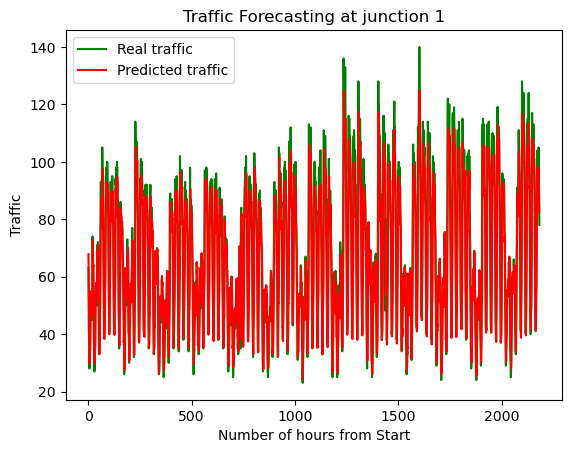

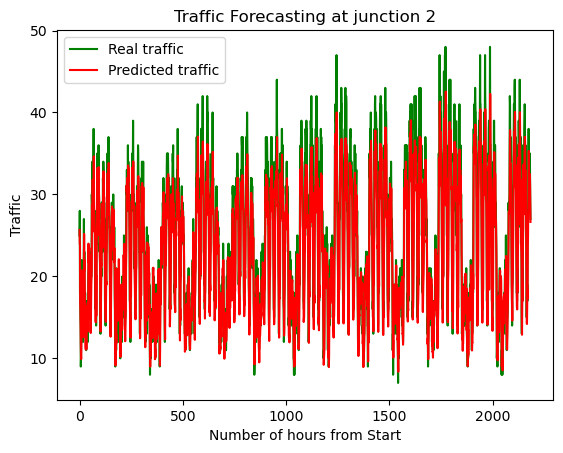

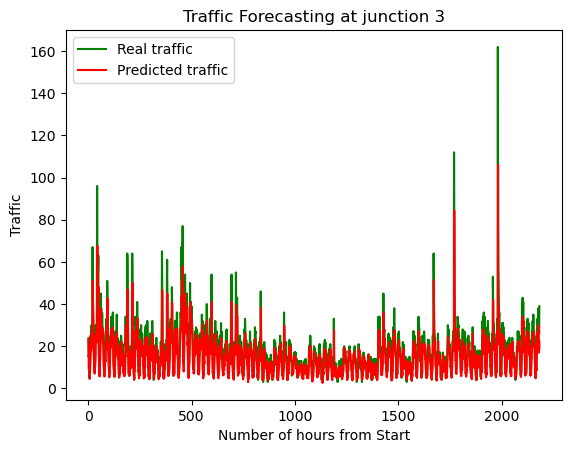

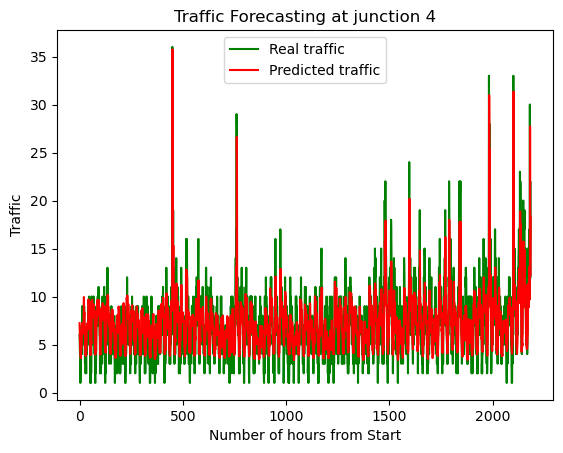

In [52]:
# Visualizing the data
# Visualising Result for the junctions
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction],color='green', label='Real traffic')
    plt.plot(y_pred[:,junction],color='red',label ='Predicted traffic')
    plt.title('Traffic Forecasting at junction %i' % (junction+1))
    plt.xlabel('Number of hours from Start')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [53]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [54]:
rmse(y_truth,y_pred)

5.9826742060816285

In [58]:
# Random Forest Classifier
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=7)
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(criterion='entropy',min_samples_split=100,min_samples_leaf=10,max_depth=12)
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt
clf.fit(X,y)
pred = clf.predict(X)
val1=(accuracy_score(y,pred)*100)
print("Accuracy Score for Random Forest :",val1*5)

C:\Users\ketan\AppData\Local\Temp\ipykernel_8868\3436135219.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)


Accuracy Score for Random Forest : 102.79509559434746


In [59]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse1(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))
rmse1(y,pred)

6.923340779406801

In [61]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X,y)
pred2 = DT.predict(X)
val2= (accuracy_score(y,pred2)*100)
print("Accuracy score for Decision tree classifer : ",val2*5)

Accuracy score for Decision tree classifer :  500.0


In [ ]:
# Support Vector Machine

from sklearn.svm import SVC 
SVM = SVC(kernel='linear')
SVM.fit(X,y)
pred3 = SVM.predict(X)
val3= (accuracy_score(y,pred3)*100)
print("Accuracy score for SVM : ",val3*5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# XGBoosting

from xgboost import XGBClassifier
XGboost = XGBClassifier(use_label_encoder=False,objective="multi:softmax",eval_metric="merror",n_estimators=20,max_depth=10,random_state=42)
XGboost.fit(X,y)
pred4=XGboost.predict(X)
val4=(accuracy_score(y,pred4)*100)
print("Accuracy score for XGBoosting : ",val4*5)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Bring some raw data
frequencies =[val1,val2,val3,val4]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['Rf','DT','SVM','XGBoost']

#plot the figure
plt.figure(figsize=(12,8))
ax= freq_series.plot(kind='bar')
ax.set_title('Evaluation of ML & Dl')
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy Range')
ax.set_xticklabels(x_labels)

def add_value_labels(ax,spacing=5):
    #for each bar: Place a label
    for rect in ax.patches:
        y_value= rect.get_height()
        x_value= rect.get_x() + rect.get_width()/2
        space=spacing
        va='bottom'
        if y_value<0:     
            space*=-1
            va='top'
        label ="{:.1f}".format(y_value)
    
    #create annotation
        ax.annotate(label,
                    (x_value,y_value),
                   xytext=(0,space),
                   textcoords="offset points",
                   ha='center',
                   va=va)
# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.show()